# Построение классфикационной модели с помощью Spark MLlib

### План:
- Подготовка данных
- Построение Пайплайна и обучение
- Оценка
- Сохранение PMML

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame
from pyspark.sql.functions import *

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
#sc = SparkContext('local')
spark = SparkSession(sc)

## Подготовка данных

In [3]:
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('BigML.csv')
df.columns

['gender',
 'age',
 'diabetes',
 'hypertension',
 'stroke',
 'heart disease',
 'smoking history',
 'BMI']

In [4]:
pd.DataFrame(df.take(5), columns=df.columns)

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,Female,80.0,0,0,0,1,never,25.19
1,Female,54.0,0,0,0,0,None,NaN
2,Male,28.0,0,0,0,0,never,NaN
3,Female,36.0,0,0,0,0,current,23.45
4,Male,76.0,0,1,0,1,current,20.14


In [5]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- heart disease: integer (nullable = true)
 |-- smoking history: string (nullable = true)
 |-- BMI: double (nullable = true)



In [6]:
df = df.filter(df.age >2)
df.count()

96713

Заполняем пустые значения:

In [7]:
def unionAll(*dfs):
    return reduce(DataFrame.union, dfs)

df = unionAll(
    df.filter(("age >=2 and age <= 9")).fillna({'smoking history': 0, 'BMI': 17.125}), 
    df.filter(('age >=10 and age <= 13')).fillna({'smoking history': 0, 'BMI':19.5}), 
    df.filter(('age >=14 and age <= 17')).fillna({'smoking history': 0, 'BMI':23.05}), 
    df.filter(('age >=18 and age <= 24')).fillna({'smoking history': 0, 'BMI':27.1}), 
    df.filter(('age >=25 and age <= 29')).fillna({'smoking history': 0, 'BMI':27.9}), 
    df.filter(('age >=30 and age <= 34')).fillna({'smoking history': 0.25, 'BMI':29.6}), 
    df.filter(('age >=35 and age <= 44')).fillna({'smoking history': 0.25, 'BMI':30.15}), 
    df.filter(('age >=45 and age <= 49')).fillna({'smoking history': 0, 'BMI':29.7}), 
    df.filter(('age >=50 and age <= 59')).fillna({'smoking history': 0, 'BMI':29.95}), 
    df.filter(('age >=60 and age <= 74')).fillna({'smoking history': 0, 'BMI':30.1}), 
    df.filter(('age > 75')).fillna({'smoking history': 0, 'BMI':28.1}))

Заменяем текстовые значения в столбце smoking history вещественными числами:

In [8]:
df = df.withColumn('gender', when(col('gender') == 'Male', 1).when(col('gender') == 'Female', 0)).na.drop(subset=["gender"])\
            .withColumn('smoking history', when(col('smoking history') == 'former', 0.75)
                        .when(col('smoking history') == 'never', 0)
                        .when(col('smoking history') == 'ever', 0.25)
                        .when(col('smoking history') == 'current', 1)
                        .when(col('smoking history') == 'not current', 0.5)
                        .otherwise(col('smoking history')))

([<matplotlib.axis.XTick at 0x7f8113fe6240>,
 <a list of 2 Text xticklabel objects>)

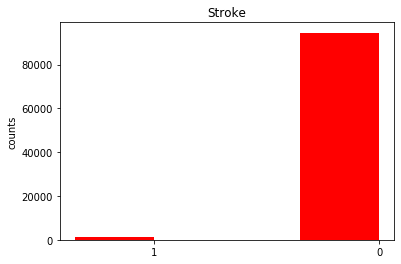

In [9]:
responses = df.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')

plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

Классы не сбалансированны, что видно по графику выше. Проводим ребалансировку:

In [10]:
sm = SMOTE(random_state=12, sampling_strategy = 'auto', n_jobs = 4)

X = df.select('gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI').toPandas()
Y = df.select('stroke').toPandas()

x_res, y_res = sm.fit_sample(X, Y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({'stroke': 1})


Разделение на тренировочную и тестовую выбору:

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(x_res, y_res, test_size=0.1, random_state=0)

In [12]:
imputeDF_train = spark.createDataFrame(
    X_train[['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI']]
    .combine_first(Y_train[['stroke']]))

In [13]:
imputeDF_test = spark.createDataFrame(
    X_test[['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI']]
    .combine_first(Y_test[['stroke']]))

([<matplotlib.axis.XTick at 0x7f811333fda0>,
 <a list of 2 Text xticklabel objects>)

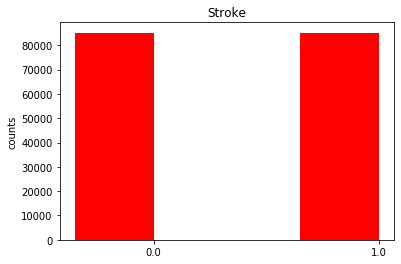

In [14]:
responses = imputeDF_train.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')

plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

Теперь классы сбалансированны.

In [15]:
imputeDF_train.show()

+------------------+------------------+--------+------+-------------+------------+--------------------+------+
|               BMI|               age|diabetes|gender|heart disease|hypertension|     smoking history|stroke|
+------------------+------------------+--------+------+-------------+------------+--------------------+------+
|              22.9|              60.0|       0|     0|            0|           0|                0.25|   0.0|
|             29.95|              52.0|       0|     0|            0|           0|                0.75|   0.0|
|             26.62|              70.0|       0|     0|            0|           1|                 0.0|   0.0|
|             32.07|              40.0|       0|     1|            0|           0|                 0.0|   0.0|
|              28.1|              78.0|       0|     1|            1|           0|                 1.0|   1.0|
|27.730959825481737|23.833973216987825|       0|     0|            0|           0|                 0.0|   1.0|
|

## Spark ML Pipeline

In [16]:
binarizer = Binarizer(threshold=0.0, inputCol="stroke", outputCol="label")

In [17]:
featureColumns = ['gender', 'age', 'diabetes', 'hypertension',
 'heart disease', 'smoking history', 'BMI']

In [18]:
assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")

In [19]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[binarizer, assembler, dt])
model = pipeline.fit(imputeDF_train)

## Оценка модели

In [20]:
predictions = model.transform(imputeDF_test)

In [21]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

Test Data Aread under ROC score is :  0.9639140761552754


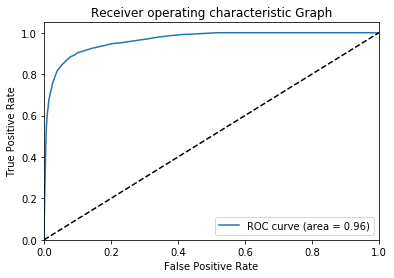

In [22]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()

In [23]:
imputeDF_train.show(5)

+-----+----+--------+------+-------------+------------+---------------+------+
|  BMI| age|diabetes|gender|heart disease|hypertension|smoking history|stroke|
+-----+----+--------+------+-------------+------------+---------------+------+
| 22.9|60.0|       0|     0|            0|           0|           0.25|   0.0|
|29.95|52.0|       0|     0|            0|           0|           0.75|   0.0|
|26.62|70.0|       0|     0|            0|           1|            0.0|   0.0|
|32.07|40.0|       0|     1|            0|           0|            0.0|   0.0|
| 28.1|78.0|       0|     1|            1|           0|            1.0|   1.0|
+-----+----+--------+------+-------------+------------+---------------+------+
only showing top 5 rows



## Сохранение PMML-файла модели

In [24]:
from pyspark.ml.feature import RFormula
formula = RFormula(formula = "stroke ~ .")
classifier = DecisionTreeClassifier(maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages = [formula, classifier])
pipelineModel = pipeline.fit(imputeDF_train)

In [25]:
from pyspark2pmml import PMMLBuilder
pmmlBuilder = PMMLBuilder(sc, imputeDF_train, pipelineModel).putOption(classifier, "compact", True)
pmmlBuilder.buildFile("dt-stroke2.pmml")

'/media/sf_share/spark-learning/dt-stroke2.pmml'